## EDA - Data Collection



Table of Contents
- Conversion of json files to 1 csv
- Topic modelling of 600 chosen articles
- Word frequency/distribution across abstracts and text body
- Reading Time frequency/distribution of text body and abstracts across the df

In [1]:
#Loading The Libraries to form the df for the project
import numpy as np # linear algebra
import pandas as pd # dataframe processing
import os
import json
#a copy is sometimes needed so one can change one copy without changing the other. 
#This module provides generic shallow and deep copy operations.
from copy import deepcopy #copy- Returns a shallow copy of any assigned variable.
import seaborn as sns
#tqdm.notebook is a IPython/Jupyter Notebook progressbar decorator for iterators. 
#Includes a default range iterator printing to stderr.
#https://tqdm.github.io/docs/notebook/
from tqdm.notebook import tqdm
#To ignore the warning message.
import warnings
warnings.filterwarnings("ignore")

CORD-19 is a corpus of academic papers about COVID-19 and related coronavirus research. It's curated and maintained by the Semantic Scholar team at the Allen Institute for AI to support text mining and NLP research.  https://www.aclweb.org/anthology/2020.nlpcovid19-acl.1/
A new dataset with updated papers is added daily, I have downloaded the october 22,2020 dataset and will be using this set for all analyses.

Source: https://github.com/allenai/cord19/blob/master/README.md

In [2]:
#Loading the metadata df
#This is the metadata for the cord 19 database and not the metadata for my project
#This will take a while ,its 4gb
metadata=pd.read_csv("metadata.csv")
metadata.head(2)

cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

## Metadata.csv overview
#### https://github.com/allenai/cord19/blob/master/README.md
- cord_uid: A str-valued field that assigns a unique identifier to each CORD-19 paper. This is not necessariy unique per row, which is explained in the FAQs.
- sha: A List[str]-valued field that is the SHA1 of all PDFs associated with the CORD-19 paper. Most papers will have either zero or one value here (since we either have a PDF or we don't), but some papers will have multiple. For example, the main paper might have supplemental information saved in a separate PDF. Or we might have two separate PDF copies of the same paper. If multiple PDFs exist, their SHA1 will be semicolon-separated (e.g. '4eb6e165ee705e2ae2a24ed2d4e67da42831ff4a; d4f0247db5e916c20eae3f6d772e8572eb828236')
- source_x: A List[str]-valued field that is the names of sources from which we received this paper. Also semicolon-separated. For example, 'ArXiv; Elsevier; PMC; WHO'. There should always be at least one source listed.
- title: A str-valued field for the paper title
- doi: A str-valued field for the paper DOI
- pmcid: A str-valued field for the paper's ID on PubMed Central. Should begin with PMC followed by an integer.
- pubmed_id: An int-valued field for the paper's ID on PubMed.
- license: A str-valued field with the most permissive license we've found associated with this paper. Possible values include: 'cc0', 'hybrid-oa', 'els-covid', 'no-cc', 'cc-by-nc-sa', 'cc-by', 'gold-oa', 'biorxiv', 'green-oa', 'bronze-oa', 'cc-by-nc', 'medrxiv', 'cc-by-nd', 'arxiv', 'unk', 'cc-by-sa', 'cc-by-nc-nd'
- abstract: A str-valued field for the paper's abstract
- publish_time: A str-valued field for the published date of the paper. This is in yyyy-mm-dd format. Not always accurate as some publishers will denote unknown dates with future dates like yyyy-12-31
- authors: A List[str]-valued field for the authors of the paper. Each author name is in Last, First Middle format and semicolon-separated.
- journal: A str-valued field for the paper journal. Strings are not normalized (e.g. BMJ and British Medical Journal can both exist). Empty string if unknown.
- mag_id: Deprecated, but originally an int-valued field for the paper as represented in the Microsoft Academic Graph.
- who_covidence_id: A str-valued field for the ID assigned by the WHO for this paper. Format looks like #72306.
- arxiv_id: A str-valued field for the arXiv ID of this paper.
- pdf_json_files: A List[str]-valued field containing paths from the root of the current data dump version to the parses of the paper PDFs into JSON format. Multiple paths are semicolon-separated. Example: document_parses/pdf_json/4eb6e165ee705e2ae2a24ed2d4e67da42831ff4a.json; document_parses/pdf_json/d4f0247db5e916c20eae3f6d772e8572eb828236.json
- pmc_json_files: A List[str]-valued field. Same as above, but corresponding to the full text XML files downloaded from PMC, parsed into the same JSON format as above.
- url: A List[str]-valued field containing all URLs associated with this paper. Semicolon-separated.
- s2_id: A str-valued field containing the Semantic Scholar ID for this paper. Can be used with the Semantic Scholar API (e.g. - s2_id=9445722 corresponds to http://api.semanticscholar.org/corpusid:9445722)

In [3]:
# data overview of the metadata set
print ('Rows     : ', metadata.shape[0])
print ('Columns  : ', metadata.shape[1])
print ('\nFeatures : ',metadata.columns.tolist())
print ('\nMissing values :  ', metadata.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',metadata.isnull().sum().values.sum()/metadata.shape[0])
print ('\nUnique values :  \n', metadata.nunique())
print ('\nThe number of duplicate rows is:', metadata.duplicated().value_counts())

Rows     :  314001
Columns  :  19

Features :  ['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']

Missing values :   2177882

Missing values percentage:   6.935907847427237

Unique values :  
 cord_uid            298917
sha                 112893
source_x                38
title               258701
doi                 192785
pmcid               121322
pubmed_id           169385
license                 18
abstract            198059
publish_time          7239
authors             223365
journal              24962
mag_id                   0
who_covidence_id    105400
arxiv_id              4003
pdf_json_files      112893
pmc_json_files       88783
url                 209719
s2_id               184531
dtype: int64

The number of duplicate rows is: False    314001
dtype: int64


I dont really need all the 4 gb of metadata because Im using only 600 research papers for my model and querrying through this huge meta data file is a waste of time and computing power.
- I will  sort it in order of the pmcid, next filter out only ids which have research articles for my analysis.
- Theres a total of 121,322PMC ids listed,however theres only 88,783 pmc papers(json format) in the oct 22,2020 dataset which has been downloaded.
- I do not need all this data to perform my analysis,I will create a smaller dataframe which contains only the rows im interested in for my analysis
- I will select only the first 600 files from the pmc_json_file column for my nlp text summarization analysis. 
- The new df has to contain all the metadata for these 600 pmc articles only.
- I will name it metadata_600


In [4]:
metadata_88k = metadata [(metadata['pmc_json_files'].notna())]
metadata_88k.head(2)

cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

In [5]:
# data overview of the metadata_88k set
print ('Rows     : ', metadata_88k.shape[0])
print ('Columns  : ', metadata_88k.shape[1])
print ('\nFeatures : ',metadata_88k.columns.tolist())
                       

Rows     :  88783
Columns  :  19

Features :  ['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']


In [6]:
#Yes,88,783 rows is exactly the number of PMC articles in the archive.
#Now to filter the top 600 articles only

In [7]:
metadata_88k.sort_values( by=['pmcid'],inplace=True)

In [8]:
metadata_600 = metadata_88k[ :600]
metadata_600.head(2)

cord_uid                                       sha      source_x  \
26      zowp10ts  03203ab50eb64271a9e825f94a1b1a6c46ea14b3           PMC   
309417  i4pmux28  f1548a1bcf0d81c278b46d24408dc7e63d9ce09d  Medline; PMC   

                                                    title  \
26      Recombination Every Day: Abundant Recombinatio...   
309417  Why can't I visit? The ethics of visitation re...   

                                 doi       pmcid    pubmed_id license  \
26      10.1371/journal.pbio.0030089  PMC1054884     15737066   cc-by   
309417                10.1186/cc2930  PMC1065028  1.54696e+07   no-cc   

                                                 abstract publish_time  \
26      Viral recombination can dramatically impact ev...   2005-03-01   
309417  Patients want, need and expect that their rela...   2004-08-31   

                                                  authors    journal  mag_id  \
26      Froissart, Remy; Roze, Denis; Uzest, Marilyne;...  PLoS Biol     NaN   
309417                                     Rogers, Sharon  Crit Care     NaN   

       who_covidence_id arxiv_id  \
26                  NaN      NaN   
309417              NaN      NaN   

                                           pdf_json_files  \
26      document_parses/pdf_json/03203ab50eb64271a9e82...   
309417  document_parses/pdf_json/f1548a1bcf0d81c278b46...   

                                      pmc_json_files  \
26      document_parses/pmc_json/PMC1054884.xml.json   
309417  document_parses/pmc_json/PMC1065028.xml.json   

                                                      url       s2_id  
26      https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...         NaN  
309417      https://www.ncbi.nlm.nih.gov/pubmed/15469583/  31130238.0

In [9]:
# data overview of the metadata_600 set
print ('Rows     : ', metadata_600.shape[0])
print ('Columns  : ', metadata_600.shape[1])
print ('\nFeatures : ',metadata_600.columns.tolist())
print ('\nMissing values :  ', metadata_600.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',metadata_600.isnull().sum().values.sum()/metadata.shape[0])
print ('\nUnique values :  \n', metadata_600.nunique())
print ('\nThe number of duplicate rows is:', metadata_600.duplicated().value_counts())

Rows     :  600
Columns  :  19

Features :  ['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']

Missing values :   2004

Missing values percentage:   0.006382145279792102

Unique values :  
 cord_uid            600
sha                 594
source_x              4
title               600
doi                 578
pmcid               600
pubmed_id           597
license              11
abstract            579
publish_time        429
authors             595
journal             129
mag_id                0
who_covidence_id      0
arxiv_id              1
pdf_json_files      594
pmc_json_files      600
url                 600
s2_id               454
dtype: int64

The number of duplicate rows is: False    600
dtype: int64


In [10]:
metadata_600=metadata_600.drop(['sha', 'mag_id','who_covidence_id','arxiv_id','pdf_json_files','pubmed_id'],axis=1)

#these are the colomn to be drop which meant to no use to me as I'm not interested in the pdf data and pubmed id
# data overview of the metadata_600 set
print ('Rows     : ', metadata_600.shape[0])
print ('Columns  : ', metadata_600.shape[1])
print ('\nFeatures : ',metadata_600.columns.tolist())

Rows     :  600
Columns  :  13

Features :  ['cord_uid', 'source_x', 'title', 'doi', 'pmcid', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'pmc_json_files', 'url', 's2_id']


The folder with all the full text articlesi.e. the json files is listed in a separate directory.
Since it is stored in JSON format,(which I've never worked with), its difficult to perform nlp analysis. 
I found some helper functions on kaggle to help me tackle this(https://www.kaggle.com/prmishra124/cord-19-eda-parse-json-and-generate-clean-csv). 
- (I've discarded my carefully organised gout nlp dataset and 
   I'm working on this set of full text articles on the 23rd of october--a week before my deadline;
   
   ----------------------------------------------------------------------------------------------------------------------------
                                   These are the names of the helper functions
* `format_name(author)`
* `format_affiliation(affiliation)`
* `format_authors(authors, with_affiliation=False)`
* `format_body(body_text)`
* `format_bib(bibs)`

In [11]:
#The helper functions to generate the authors name,affiliation,article body and bibliography:
#https://www.kaggle.com/prmishra124/cord-19-eda-parse-json-and-generate-clean-csv

def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

In [12]:
def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

In [13]:
def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

In [14]:
def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

In [15]:
# Some more helper functions.Thank God for Kaggle!
#load_files(dirname) - loads the name of the directory in which the jsons are saved
#generate_clean_df(all_files) - Finally generates the cleaned csv's
#In order to simplify things,I am not writing a finction to include 
#the abstract in the text body as the abstract will interfere with the extractive summarization

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            
        
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df.head()
    
    return clean_df

In [16]:
''' Reading the individual json files into one list
sorce code to convert the json into clean pdf files is from 
 https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv'''


#Retreiving json files from the directory
# Printing the total number of files- there are 88,783 articles

biorxiv_dir = 'PMC_papers/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))


Number of articles retrieved from biorxiv: 600


In [17]:

#A loop to open and read the json files in the directory and list all the files in the all_files list

all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [18]:
#get the dictionary keys for all the files in the list
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'body_text', 'ref_entries', 'back_matter', 'bib_entries'])


In [19]:
#Let's see what the grouped section titles are for the example above:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

print(list(texts_di.keys()))

['Introduction', 'Recombinant Frequency in CaMV Populations from Co-Infected Plants ::: Results', 'Probability of Recombination between Various Pairs of Markers ::: Results', 'Discussion', 'Viral isolates :::  ::: Materials and Methods', 'Production of viral particles and co-inoculation :::  ::: Materials and Methods', 'Estimation of marker frequency within mixed virus populations :::  ::: Materials and Methods', 'Isolation of individual CaMV genomes and identification of recombinants :::  ::: Materials and Methods', 'Statistical analysis :::  ::: Materials and Methods']


In [20]:
#The function below lets you display the body text in one line (unhide to see exactly the same as above):
print(format_body(file['body_text'])[:3000])

Introduction

As increasing numbers of full-length viral sequences become available, recombinant or mosaic viruses are being recognized more frequently [1,2,3]. Recombination events have been demonstrated to be associated with viruses expanding their host range [4,5,6,7] or increasing their virulence [8,9], thus accompanying, or perhaps even being at the origin of, major changes during virus adaptation. It remains unclear, however, whether recombination events represent a highly frequent and significant phenomenon in the everyday life of these viruses.Viruses can exchange genetic material when at least two different viral genomes co-infect the same host cell. Progeny can then become hybrid through different mechanisms, such as reassortment of segments when the parental genomes are fragmented [10], intra-molecular recombination when polymerases switch templates (in RNA viruses) [11], or homologous or non-homologous recombination (in both RNA and DNA viruses). Quantification of viral rec

Generating the Metadata
Its recommended to always documents the metadata.
Below, I will code the cells which generate the metadata. 
Source code:Courtesy of Kaggle https://www.kaggle.com/saga21/cord-19-data-extraction-functions

### The Refence/Bibliography Section
Let's take a look at the bibliography section dictionary

In [21]:
#Using the helper functions created at the beginning to convert the json files into csv files in a single df
cleaned_files = []

for file in tqdm (all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

In [22]:
#Set the column names for the df
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head()

paper_id                                              title  \
0  PMC1054884  Recombination Every Day: Abundant Recombinatio...   
1  PMC1065028  Why can't I visit? The ethics of visitation re...   
2  PMC1065064  Prospective evaluation of an internet-linked h...   
3  PMC1065120  Scanning the horizon: emerging hospital-wide t...   
4  PMC1065257  Characterization of the frameshift signal of E...   

                                             authors  \
0  Remy Froissart, Denis Roze, Marilyne Uzest, Li...   
1                                      Sharon Rogers   
2  Stephen E Lapinsky, Randy Wax, Randy Showalter...   
3  Ganesh Suntharalingam, Jonathan Cousins, David...   
4  Emily Manktelow, Kazuhiro Shigemoto, Ian Brierley   

                                        affiliations  \
0  Remy Froissart, Denis Roze, Marilyne Uzest, Li...   
1                                      Sharon Rogers   
2  Stephen E Lapinsky, Randy Wax, Randy Showalter...   
3  Ganesh Suntharalingam, Jonathan Cousins, David...   
4  Emily Manktelow, Kazuhiro Shigemoto, Ian Brierley   

                                                text  \
0  Introduction\n\nAs increasing numbers of full-...   
1  Introduction\n\nThe sudden emergence of severe...   
2  Introduction\n\nThe rate of expansion of medic...   
3  Introduction\n\nThis series of articles provid...   
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...   

                                        bibliography  \
0  The evolutionary genomics of pathogen recombin...   
1  , , Learning Lessons from the Toronto Experien...   
2  Ventilation with lower tidal volumes as compar...   
3  Use of the Internet in scanning the horizon fo...   
4  Expression of the Rous sarcoma virus pol gene ...   

                                         raw_authors  \
0  [{'first': 'Remy', 'middle': [], 'last': 'Froi...   
1  [{'first': 'Sharon', 'middle': [], 'last': 'Ro...   
2  [{'first': 'Stephen', 'middle': ['E'], 'last':...   
3  [{'first': 'Ganesh', 'middle': [], 'last': 'Su...   
4  [{'first': 'Emily', 'middle': [], 'last': 'Man...   

                                    raw_bibliography  
0  {'BIBREF0': {'title': 'The evolutionary genomi...  
1  {'BIBREF0': {'title': '', 'authors': [], 'year...  
2  {'BIBREF0': {'title': 'Ventilation with lower ...  
3  {'BIBREF0': {'title': 'Use of the Internet in ...  
4  {'BIBREF0': {'title': 'Expression of the Rous ...

In [23]:
# data overview of the metadata set
print ('Rows     : ', clean_df.shape[0])
print ('Columns  : ', clean_df.shape[1])
print ('\nFeatures : ',clean_df.columns.tolist())
print ('\nMissing values :  ', clean_df.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',clean_df.isnull().sum().values.sum()/clean_df.shape[0])


Rows     :  600
Columns  :  8

Features :  ['paper_id', 'title', 'authors', 'affiliations', 'text', 'bibliography', 'raw_authors', 'raw_bibliography']

Missing values :   0

Missing values percentage:   0.0


In [24]:
df = clean_df.drop(['affiliations','raw_bibliography','raw_authors'], axis=1) 
#these are the colomn to be drop which meant to no use to me .
df.head(5)

paper_id                                              title  \
0  PMC1054884  Recombination Every Day: Abundant Recombinatio...   
1  PMC1065028  Why can't I visit? The ethics of visitation re...   
2  PMC1065064  Prospective evaluation of an internet-linked h...   
3  PMC1065120  Scanning the horizon: emerging hospital-wide t...   
4  PMC1065257  Characterization of the frameshift signal of E...   

                                             authors  \
0  Remy Froissart, Denis Roze, Marilyne Uzest, Li...   
1                                      Sharon Rogers   
2  Stephen E Lapinsky, Randy Wax, Randy Showalter...   
3  Ganesh Suntharalingam, Jonathan Cousins, David...   
4  Emily Manktelow, Kazuhiro Shigemoto, Ian Brierley   

                                                text  \
0  Introduction\n\nAs increasing numbers of full-...   
1  Introduction\n\nThe sudden emergence of severe...   
2  Introduction\n\nThe rate of expansion of medic...   
3  Introduction\n\nThis series of articles provid...   
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...   

                                        bibliography  
0  The evolutionary genomics of pathogen recombin...  
1  , , Learning Lessons from the Toronto Experien...  
2  Ventilation with lower tidal volumes as compar...  
3  Use of the Internet in scanning the horizon fo...  
4  Expression of the Rous sarcoma virus pol gene ...

In [25]:
#Check for duplicates
df.duplicated().sum()

0

In [26]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 5)


In [27]:
#There are 0 rows which are duplicated and 5 columns
# Im crosschecking for duplication by viewing the duplicated df

duplicate_rows_df

Empty DataFrame
Columns: [paper_id, title, authors, text, bibliography]
Index: []

In [28]:
df.head(2)

paper_id                                              title  \
0  PMC1054884  Recombination Every Day: Abundant Recombinatio...   
1  PMC1065028  Why can't I visit? The ethics of visitation re...   

                                             authors  \
0  Remy Froissart, Denis Roze, Marilyne Uzest, Li...   
1                                      Sharon Rogers   

                                                text  \
0  Introduction\n\nAs increasing numbers of full-...   
1  Introduction\n\nThe sudden emergence of severe...   

                                        bibliography  
0  The evolutionary genomics of pathogen recombin...  
1  , , Learning Lessons from the Toronto Experien...

In [29]:
metadata_600.head(2)

cord_uid      source_x  \
26      zowp10ts           PMC   
309417  i4pmux28  Medline; PMC   

                                                    title  \
26      Recombination Every Day: Abundant Recombinatio...   
309417  Why can't I visit? The ethics of visitation re...   

                                 doi       pmcid license  \
26      10.1371/journal.pbio.0030089  PMC1054884   cc-by   
309417                10.1186/cc2930  PMC1065028   no-cc   

                                                 abstract publish_time  \
26      Viral recombination can dramatically impact ev...   2005-03-01   
309417  Patients want, need and expect that their rela...   2004-08-31   

                                                  authors    journal  \
26      Froissart, Remy; Roze, Denis; Uzest, Marilyne;...  PLoS Biol   
309417                                     Rogers, Sharon  Crit Care   

                                      pmc_json_files  \
26      document_parses/pmc_json/PMC1054884.xml.json   
309417  document_parses/pmc_json/PMC1065028.xml.json   

                                                      url       s2_id  
26      https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...         NaN  
309417      https://www.ncbi.nlm.nih.gov/pubmed/15469583/  31130238.0

In [30]:
#I need the abstracts and other data from the metadata df 
#both dfs share the the pmc id.However, the pmc id is labelled as the paper_id in the article df
text_df=pd.merge (metadata_600, df, left_on='pmcid', right_on='paper_id')
text_df.head(2)

cord_uid      source_x                                            title_x  \
0  zowp10ts           PMC  Recombination Every Day: Abundant Recombinatio...   
1  i4pmux28  Medline; PMC  Why can't I visit? The ethics of visitation re...   

                            doi       pmcid license  \
0  10.1371/journal.pbio.0030089  PMC1054884   cc-by   
1                10.1186/cc2930  PMC1065028   no-cc   

                                            abstract publish_time  \
0  Viral recombination can dramatically impact ev...   2005-03-01   
1  Patients want, need and expect that their rela...   2004-08-31   

                                           authors_x    journal  \
0  Froissart, Remy; Roze, Denis; Uzest, Marilyne;...  PLoS Biol   
1                                     Rogers, Sharon  Crit Care   

                                 pmc_json_files  \
0  document_parses/pmc_json/PMC1054884.xml.json   
1  document_parses/pmc_json/PMC1065028.xml.json   

                                                 url       s2_id    paper_id  \
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...         NaN  PMC1054884   
1      https://www.ncbi.nlm.nih.gov/pubmed/15469583/  31130238.0  PMC1065028   

                                             title_y  \
0  Recombination Every Day: Abundant Recombinatio...   
1  Why can't I visit? The ethics of visitation re...   

                                           authors_y  \
0  Remy Froissart, Denis Roze, Marilyne Uzest, Li...   
1                                      Sharon Rogers   

                                                text  \
0  Introduction\n\nAs increasing numbers of full-...   
1  Introduction\n\nThe sudden emergence of severe...   

                                        bibliography  
0  The evolutionary genomics of pathogen recombin...  
1  , , Learning Lessons from the Toronto Experien...

In [31]:
#Theres a couple of redundant column, these can be dropped
print('Columns:', text_df.columns.tolist())
print('------------------------------------------------------------------------------------------------------------------------')
print('Shape of text_df:',text_df.shape)

Columns: ['cord_uid', 'source_x', 'title_x', 'doi', 'pmcid', 'license', 'abstract', 'publish_time', 'authors_x', 'journal', 'pmc_json_files', 'url', 's2_id', 'paper_id', 'title_y', 'authors_y', 'text', 'bibliography']
------------------------------------------------------------------------------------------------------------------------
Shape of text_df: (526, 18)


In [32]:
#The title, paper_id and authors are duplicated across the rows.These redundant columns can be dropped
text_df =  text_df.drop(['authors_y','url','bibliography','s2_id','paper_id', 'title_y','source_x','doi','license','publish_time','pmc_json_files'], axis=1) 
#these are the colomn to be drop which meant to no use to me .
print('Columns:', text_df.columns.tolist())
print('------------------------------------------------------------------------------------------------------------------------')
print('Shape of text_df:',text_df.shape)


Columns: ['cord_uid', 'title_x', 'pmcid', 'abstract', 'authors_x', 'journal', 'text']
------------------------------------------------------------------------------------------------------------------------
Shape of text_df: (526, 7)


In [33]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526 entries, 0 to 525
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cord_uid   526 non-null    object
 1   title_x    526 non-null    object
 2   pmcid      526 non-null    object
 3   abstract   508 non-null    object
 4   authors_x  525 non-null    object
 5   journal    526 non-null    object
 6   text       526 non-null    object
dtypes: object(7)
memory usage: 32.9+ KB


Now that the data frames are merged, Im down to 526 articles, from 600.However, I only have 508 abstracts. I can drop the rest of the dataset, where there is no abstract.

In [34]:
print ('\nMissing values :  ', text_df.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',text_df.isnull().sum()/text_df.shape[0])


Missing values :   19

Missing values percentage:   cord_uid     0.000000
title_x      0.000000
pmcid        0.000000
abstract     0.034221
authors_x    0.001901
journal      0.000000
text         0.000000
dtype: float64


In [35]:
#My intent was to summarize 500 articles, I have missing abstracts for 18 papers, and I need those cells.
#For the sake of uniformity, Im droping the 18 rows without abstracts and the 1 row without the authors details.
# T will be left with ~500 article texts and summaries.

text_df.dropna(inplace=True)

In [36]:
text_df.head()

cord_uid                                            title_x       pmcid  \
0  zowp10ts  Recombination Every Day: Abundant Recombinatio...  PMC1054884   
1  i4pmux28  Why can't I visit? The ethics of visitation re...  PMC1065028   
2  jw1lxwyd  Prospective evaluation of an internet-linked h...  PMC1065064   
3  xiv9vxdp  Scanning the horizon: emerging hospital-wide t...  PMC1065120   
4  mcfmxqp2  Characterization of the frameshift signal of E...  PMC1065257   

                                            abstract  \
0  Viral recombination can dramatically impact ev...   
1  Patients want, need and expect that their rela...   
2  INTRODUCTION: Critical care physicians may ben...   
3  This commentary represents a selective survey ...   
4  The ribosomal frameshifting signal of the mous...   

                                           authors_x            journal  \
0  Froissart, Remy; Roze, Denis; Uzest, Marilyne;...          PLoS Biol   
1                                     Rogers, Sharon          Crit Care   
2  Lapinsky, Stephen E; Wax, Randy; Showalter, Ra...          Crit Care   
3  Suntharalingam, Ganesh; Cousins, Jonathan; Gat...          Crit Care   
4  Manktelow, Emily; Shigemoto, Kazuhiro; Brierle...  Nucleic Acids Res   

                                                text  
0  Introduction\n\nAs increasing numbers of full-...  
1  Introduction\n\nThe sudden emergence of severe...  
2  Introduction\n\nThe rate of expansion of medic...  
3  Introduction\n\nThis series of articles provid...  
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...

In [37]:
 #Some of the columns have x and y added to their names after the merge
#Im renaming columns and removing the _x and _y's from them
text_df.rename(columns={'cord_uid':'cord_uid','title_x':'title','pmcid':'pmcid','abstract':'abstract','authors_x':'authors','journal':'journal','text':'text_body'
                          }, 
                 inplace=True)

In [38]:
text_df.head()

cord_uid                                              title       pmcid  \
0  zowp10ts  Recombination Every Day: Abundant Recombinatio...  PMC1054884   
1  i4pmux28  Why can't I visit? The ethics of visitation re...  PMC1065028   
2  jw1lxwyd  Prospective evaluation of an internet-linked h...  PMC1065064   
3  xiv9vxdp  Scanning the horizon: emerging hospital-wide t...  PMC1065120   
4  mcfmxqp2  Characterization of the frameshift signal of E...  PMC1065257   

                                            abstract  \
0  Viral recombination can dramatically impact ev...   
1  Patients want, need and expect that their rela...   
2  INTRODUCTION: Critical care physicians may ben...   
3  This commentary represents a selective survey ...   
4  The ribosomal frameshifting signal of the mous...   

                                             authors            journal  \
0  Froissart, Remy; Roze, Denis; Uzest, Marilyne;...          PLoS Biol   
1                                     Rogers, Sharon          Crit Care   
2  Lapinsky, Stephen E; Wax, Randy; Showalter, Ra...          Crit Care   
3  Suntharalingam, Ganesh; Cousins, Jonathan; Gat...          Crit Care   
4  Manktelow, Emily; Shigemoto, Kazuhiro; Brierle...  Nucleic Acids Res   

                                           text_body  
0  Introduction\n\nAs increasing numbers of full-...  
1  Introduction\n\nThe sudden emergence of severe...  
2  Introduction\n\nThe rate of expansion of medic...  
3  Introduction\n\nThis series of articles provid...  
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...

<AxesSubplot:>

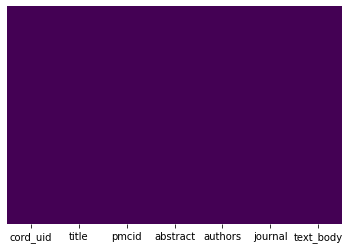

In [39]:
#visualizing the null values
sns.heatmap(text_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#If I see a clear purple plot, I have no null values across the columns

In [40]:
#The libraries used for feature engineering and eda
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import re
import gensim
import gensim.corpora as corpora
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Non-Negative Matrix Factorization (NMF) is an unsupervised technique, so 
#there is no labeling of topics that the model has to be trained on
from sklearn.decomposition import NMF
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda

# topic modelling source:https://medium.com/@obianuju.c.okafor/automatic-topic-classification-of-research-papers-using-the-nlp-topic-model-nmf-d4365987ec82

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GregFlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GregFlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Wireframe of NLP data used for the capstone
- **cord_uid**: The unique CORD 19 User Identification number assigned to the article 
- **title**: The title of the article
- **pmcid**: The PMC article unique identification number
- **abstract**: The abstract of the article
- **authors**: The name of the article's authors 	
- **journal**: The name of the journal, the article was published in
- **text_body**: The article without the abstract, reference and acknowlegement section

In [41]:
#Writing this merged df to a csv file, so that I dont have to go through all that hassel and
#won't waste computing power, while modeling the summarizer
text_df.to_csv(r'capstone_data.csv',index=False)

In [42]:
#Load data file
entire_dataset = pd.read_csv('capstone_data.csv')
entire_dataset.head()

cord_uid                                              title       pmcid  \
0  zowp10ts  Recombination Every Day: Abundant Recombinatio...  PMC1054884   
1  i4pmux28  Why can't I visit? The ethics of visitation re...  PMC1065028   
2  jw1lxwyd  Prospective evaluation of an internet-linked h...  PMC1065064   
3  xiv9vxdp  Scanning the horizon: emerging hospital-wide t...  PMC1065120   
4  mcfmxqp2  Characterization of the frameshift signal of E...  PMC1065257   

                                            abstract  \
0  Viral recombination can dramatically impact ev...   
1  Patients want, need and expect that their rela...   
2  INTRODUCTION: Critical care physicians may ben...   
3  This commentary represents a selective survey ...   
4  The ribosomal frameshifting signal of the mous...   

                                             authors            journal  \
0  Froissart, Remy; Roze, Denis; Uzest, Marilyne;...          PLoS Biol   
1                                     Rogers, Sharon          Crit Care   
2  Lapinsky, Stephen E; Wax, Randy; Showalter, Ra...          Crit Care   
3  Suntharalingam, Ganesh; Cousins, Jonathan; Gat...          Crit Care   
4  Manktelow, Emily; Shigemoto, Kazuhiro; Brierle...  Nucleic Acids Res   

                                           text_body  
0  Introduction\n\nAs increasing numbers of full-...  
1  Introduction\n\nThe sudden emergence of severe...  
2  Introduction\n\nThe rate of expansion of medic...  
3  Introduction\n\nThis series of articles provid...  
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...

In [43]:
#selecting just the first two columns and dropping the unnecessary columns
#At this point, I need only the title, abstract and text body
#the reason I used slice notation was because I was trying to process n number of rows before I processed all 500 articles
#also using df.drop became boring
df=entire_dataset [['title','abstract','text_body']][:500]

In [44]:
#displaying the newly created df
df.shape

(500, 3)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      500 non-null    object
 1   abstract   500 non-null    object
 2   text_body  500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [46]:
# creating specific functions for lemmatization,lowercasing words, removing punctuation and tokenization
#function for lemmatization
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# tokenization
tokenized_data = df['text_body'].apply(lambda x: x.split()) 

# Remove punctuation from the tokenized words
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\\!?]', '', item) for item in x])
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[.]', ' ', item) for item in x])

#convert words to lowercase
tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])

# remove stop-words and words of length less than 3
# add a couple of stopwords that are common in articles
stop_words = stopwords.words('english')
stop_words.extend(['et','al', 'introduction','conclusion','materials and methods', 'fig',
                   'methodology', 'et.', 'all', 'team','image','table','tables','figures', 'figure','result'])
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>3])

#lemmatize already tokenized sentences by calling lemmatization function on tokenized text
tokenized_data= tokenized_data.apply(lambda x: [get_lemma(item) for item in x])

In [47]:
# Build a list of bigram(2 consecutive words) and a list of trigram models(3 consecutive words)
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram using gensims inbuilt features
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# check trigram example
print(trigram_mod[bigram_mod[tokenized_data[0]]])

['increase_numbers', 'fulllength', 'viral', 'sequence', 'become_available', 'recombinant', 'mosaic_virus', 'recognize', 'frequently', '[123] ', 'recombination_event', 'demonstrate', 'associate', 'virus', 'expand', 'host_range', '[4567]', 'increase_virulence', '[89]', 'thus', 'accompany', 'perhaps', 'even', 'origin', 'major', 'change', 'virus', 'adaptation ', 'remains_unclear', 'however', 'whether', 'recombination_event', 'represent', 'highly', 'frequent', 'significant', 'phenomenon', 'everyday', 'life', 'viruses viruses', 'exchange', 'genetic_material', 'least', 'different', 'viral_genome', 'coinfect', 'host_cell ', 'progeny', 'become', 'hybrid', 'different', 'mechanism', 'reassortment', 'segment', 'parental', 'genome', 'fragment', '[10]', 'intramolecular', 'recombination', 'polymerase', 'switch', 'template', 'virus', '[11]', 'homologous_nonhomologous', 'recombination', 'viruses ', 'quantification', 'viral', 'recombination', 'multicellular', 'organism', 'attempt', 'distinct', 'experime

In [48]:
# Define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [49]:

# Form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

 # Form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [50]:

# de-tokenization, combine tokens together
detokenized_data = []
for i in range(len(df['text_body'])):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)
    
df['clean_text']= detokenized_data 
documents = df['clean_text']

In [51]:
#check if the tokenizer worked and if a new column was created
df.head()

title  \
0  Recombination Every Day: Abundant Recombinatio...   
1  Why can't I visit? The ethics of visitation re...   
2  Prospective evaluation of an internet-linked h...   
3  Scanning the horizon: emerging hospital-wide t...   
4  Characterization of the frameshift signal of E...   

                                            abstract  \
0  Viral recombination can dramatically impact ev...   
1  Patients want, need and expect that their rela...   
2  INTRODUCTION: Critical care physicians may ben...   
3  This commentary represents a selective survey ...   
4  The ribosomal frameshifting signal of the mous...   

                                           text_body  \
0  Introduction\n\nAs increasing numbers of full-...   
1  Introduction\n\nThe sudden emergence of severe...   
2  Introduction\n\nThe rate of expansion of medic...   
3  Introduction\n\nThis series of articles provid...   
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...   

                                          clean_text  
0  increase_numbers fulllength viral sequence bec...  
1  sudden emergence severe_acute_respiratory_synd...  
2  rate expansion medical knowledge increase rapi...  
3  series article provide regular surveillance te...  
4  program_ribosomal_frameshifting hereafter fram...

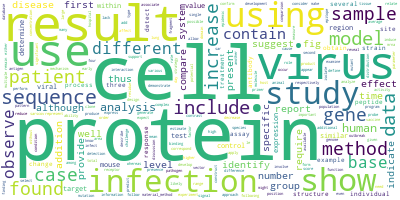

In [52]:
# Join the different processed titles together.
long_string = ','.join(list(documents.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=5, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()
#wow cell really pops out
#many people in the biotech community are trying to create a vaccine for covid
# the words cell and protein popping out are due to the numerous  article titles on covid virus research
#virus cells + proteins= present in the title of most papers
#makes sense to me...
#Ilove these shades of blue-green, its calming hence steelblue

In [53]:
long_string

'increase_numbers fulllength viral sequence become_available recombinant mosaic_virus recognize frequently [123]  recombination_event demonstrate associate virus expand host_range [4567] increase_virulence [89] thus accompany perhaps even origin major change virus adaptation  remains_unclear however whether recombination_event represent highly frequent significant phenomenon everyday life viruses viruses exchange genetic_material least different viral_genome coinfect host_cell  progeny become hybrid different mechanism reassortment segment parental genome fragment [10] intramolecular recombination polymerase switch template virus [11] homologous_nonhomologous recombination viruses  quantification viral recombination multicellular organism attempt distinct experimental approaches: vitro cell_culture [12131415] vivo live host [161718]  vitro approach apply animal virus allow establishment “intrinsic” recombination_rate experimentally coinfected cell cell_culture [141519]  however necessa

In [54]:

#Set variable number of terms 
#Im feeling adventerous, ive chosen 1000 words in all 600 articles, excluding the stopwords
no_terms = 1000
#Non-Negative Matrix Factorization (NMF) is an unsupervised ml technique to get topics from text
# NMF uses the tf-idf count vectorizer
# Initialise the count vectorizer with the English stop words
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=no_terms, stop_words='english')
# Fit and transform the text
document_matrix = vectorizer.fit_transform(documents)

#get features
feature_names = vectorizer.get_feature_names()

In [55]:
#Set variables umber of topics and top words.
#you can adjust the number of clusters/topics you require by changing the no_topics.
#I personallly feel that since there are 600 articles,no_topics of 10 would be sufficient
no_topics = 10
no_top_words = 10

# Function for displaying topics
#This function draws out 10 of the hottest topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    print("Model Result:")
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    dict = pd.DataFrame(word_dict);
    dict.to_csv('%s.csv' % model_name)
    return dict

# Apply NMF topic model to document-term matrix
nmf_model = NMF(n_components=no_topics, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd').fit(document_matrix)
#display topics for nmf model

display_topic(nmf_model, feature_names, no_topics, no_top_words, 'NMF_Model_Result')
#The top ten topics‘are displayed below Topic #03 is about covid patients
#we can infer that patients are hospitalized because of sars(covid is a form of sars) 
#and patients have pneumonia-an infection in their lungs
# All of the 500 papers in the dataset falls under one of these 10 topics areas. 
#Thus, I can use topic modelling to effectively classify the papers based on the content in them, rather thatn the title.
#This will minimize errors due to my laziness and prevent judging a book by its cover.i.e reducing bias
#the generated topics thus classify every paper in the corpus.

Model Result:


Topic # 00     Topic # 01  Topic # 02    Topic # 03  Topic # 04  \
0         fig         health       mouse       patient     peptide   
1     binding  public_health         fig          ards     epitope   
2      mutant    information        lung      patients     binding   
3     residue        country  expression         child     residue   
4      domain         access        mice          sars  prediction   
5    receptor         public    response     treatment    position   
6      fusion       hospital        ifnγ     pneumonia  amino_acid   
7    membrane         global       _cell  sars_patient     predict   
8  expression       response    cytokine      clinical     antigen   
9   structure         survey       brain      hospital    antibody   

          Topic # 05     Topic # 06    Topic # 07     Topic # 08  \
0            sarscov          probe      outbreak  frameshifting   
1               sars         genome      epidemic     pseudoknot   
2               ace2         primer      estimate           stem   
3  sarscov_infection      detection  transmission       ribosome   
4       sars_patient          array     parameter           mrna   
5               lung  hybridization        assume           loop   
6             animal     microarray  distribution      structure   
7              serum       database  intervention          codon   
8           genotype        species        infect         signal   
9             infect       pathogen     influenza    translation   

        Topic # 09  
0          vaccine  
1           vector  
2          antigen  
3     immunization  
4         antibody  
5      vaccination  
6       protection  
7        challenge  
8  immune_response  
9           animal

In [56]:
# Visualize the topics
#pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. 
#The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.
#This is so cool,Its computationally expensive because of the interactivity
#https://pyldavis.readthedocs.io/en/latest/readme.html#:~:text=pyLDAvis%20is%20designed%20to%20help,an%20interactive%20web%2Dbased%20visualization.
pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(nmf_model, document_matrix, vectorizer)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.043028  0.107595       1        1  21.945452
6     -0.073991  0.164887       2        1  17.973430
1     -0.251286  0.086240       3        1  13.805932
2      0.011989 -0.135344       4        1  12.031687
3     -0.215031 -0.065382       5        1  11.085769
7     -0.230807  0.068833       6        1   7.747198
9      0.136011 -0.216081       7        1   4.448433
5      0.062399 -0.302023       8        1   4.387034
4      0.223219  0.067993       9        1   4.160325
8      0.294470  0.223283      10        1   2.414740, topic_info=           Term       Freq      Total Category  logprob  loglift
805     sarscov  48.000000  48.000000  Default  30.0000  30.0000
648     peptide  40.000000  40.000000  Default  29.0000  29.0000
803        sars  34.000000  34.000000  Default  28.0000  28.0000
958     vaccine  24.000000  24.000000  Default  27.0000  27.0000
643     patient  37.000000  37.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
846        site   1.013949  10.135278  Topic10  -4.5989   1.4214
428        hiv1   0.829594   8.022616  Topic10  -4.7996   1.4545
681     predict   1.015644  11.710317  Topic10  -4.5973   1.2786
675    position   0.762551  10.220585  Topic10  -4.8839   1.1281
357  expression   0.850764  15.400100  Topic10  -4.7744   0.8276

[452 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
10        1  0.899525   1993
11        1  0.890136   1994
12        1  0.976041   1995
13        1  1.000677   1996
14        1  0.900562   1997
...     ...       ...    ...
996       3  0.334279  years
996       5  0.501418  years
996       6  0.167139  years
997       1  0.679186  yeast
997      10  0.226395  yeast

[804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 3, 4, 8, 10, 6, 5, 9])

In [57]:
#Finally,  the 10 topics generated by the NMF model is used to categorize all 600 papers in my dataset.
#Use NMF model to assign topic to papers in corpus and write it to a csv
# Because I dont trust jupyter
nmf_topic_values = nmf_model.transform(document_matrix)
df['NMF Topic'] = nmf_topic_values.argmax(axis=1)

#Save dataframe to csv file
df.to_csv('topic_modelling_results.csv')


### Feature Engineering

In [58]:
entire_dataset.head()

cord_uid                                              title       pmcid  \
0  zowp10ts  Recombination Every Day: Abundant Recombinatio...  PMC1054884   
1  i4pmux28  Why can't I visit? The ethics of visitation re...  PMC1065028   
2  jw1lxwyd  Prospective evaluation of an internet-linked h...  PMC1065064   
3  xiv9vxdp  Scanning the horizon: emerging hospital-wide t...  PMC1065120   
4  mcfmxqp2  Characterization of the frameshift signal of E...  PMC1065257   

                                            abstract  \
0  Viral recombination can dramatically impact ev...   
1  Patients want, need and expect that their rela...   
2  INTRODUCTION: Critical care physicians may ben...   
3  This commentary represents a selective survey ...   
4  The ribosomal frameshifting signal of the mous...   

                                             authors            journal  \
0  Froissart, Remy; Roze, Denis; Uzest, Marilyne;...          PLoS Biol   
1                                     Rogers, Sharon          Crit Care   
2  Lapinsky, Stephen E; Wax, Randy; Showalter, Ra...          Crit Care   
3  Suntharalingam, Ganesh; Cousins, Jonathan; Gat...          Crit Care   
4  Manktelow, Emily; Shigemoto, Kazuhiro; Brierle...  Nucleic Acids Res   

                                           text_body  
0  Introduction\n\nAs increasing numbers of full-...  
1  Introduction\n\nThe sudden emergence of severe...  
2  Introduction\n\nThe rate of expansion of medic...  
3  Introduction\n\nThis series of articles provid...  
4  INTRODUCTION\n\nProgrammed −1 ribosomal frames...

In [59]:
sum_df= entire_dataset.drop(['title','pmcid','authors','journal'], axis=1)

In [60]:
#A little bit of superficial cleaning

def clean_dataset(text):
    text=re.sub("[\[].*?[\]]", "", str(text))  #remove in-text citation
    text=re.sub(r'^https?:\/\/.*[\r\n]*', '',text, flags=re.MULTILINE)#remove hyperlink
    text=re.sub(r'^a1111111111 a1111111111 a1111111111 a1111111111 a1111111111.*[\r\n]*',' ',text)#some text has a11111.. 
    text=re.sub(r' +', ' ',text ) #remove extra space
    text=re.sub(r's/ ( *)/\1/g','',text)
    
    return text

<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: DeprecationWarning: invalid escape sequence \[
<input>:4: Dep

In [61]:
# Apply the clean_data function to the abstract, text and title of the articles

sum_df['text_body'] =sum_df['text_body'].apply(clean_dataset)
sum_df['abstract'] =sum_df['abstract'].apply(clean_dataset)

In [62]:
#Generating the text body of the first aricle
sum_df['text_body'][0]

"Introduction\n\nAs increasing numbers of full-length viral sequences become available, recombinant or mosaic viruses are being recognized more frequently . Recombination events have been demonstrated to be associated with viruses expanding their host range or increasing their virulence , thus accompanying, or perhaps even being at the origin of, major changes during virus adaptation. It remains unclear, however, whether recombination events represent a highly frequent and significant phenomenon in the everyday life of these viruses.Viruses can exchange genetic material when at least two different viral genomes co-infect the same host cell. Progeny can then become hybrid through different mechanisms, such as reassortment of segments when the parental genomes are fragmented , intra-molecular recombination when polymerases switch templates (in RNA viruses) , or homologous or non-homologous recombination (in both RNA and DNA viruses). Quantification of viral recombination in multi-cellula

In [63]:
#Count the words in the abstract and print min to max and average
sum_df['count_abstract'] = sum_df['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
print('The min word count in abstract is:',sum_df['count_abstract'].min())
print('The max word count in abstract is:',sum_df['count_abstract'].max())
print('The average word count in abstract is:',sum_df['count_abstract'].mean());

print('---------------------------------------------------------------------')
#Count the words in the text body and print min to max and average
sum_df['count_text'] = sum_df['text_body'].apply(lambda x: len(x.strip().split()))  # word count in body
print('The min word count in text body is:',sum_df['count_text'].min())
print('The max word count in text body is:',sum_df['count_text'].max())
print('The average word count in text body is:',sum_df['count_text'].mean());
print('---------------------------------------------------------------------')

#Count the unique words in the text body and print min to max and average
sum_df['count_unique'] = sum_df['text_body'].apply(lambda x:len(set(str(x).split()))) 
print('The min unique word count in text body is:',sum_df['count_unique'].min())
print('The max unique word count in text body is:',sum_df['count_unique'].max())
print('The average unique word count in text body is:',sum_df['count_unique'].mean());

# Reading time
#average read time is 265 words a minute
#Dividing the total no of words by 265 gives the reading time of the article
sum_df['article_read_time'] = sum_df['count_text']/265



The min word count in abstract is: 14
The max word count in abstract is: 543
The average word count in abstract is: 209.01577909270216
---------------------------------------------------------------------
The min word count in text body is: 692
The max word count in text body is: 13101
The average word count in text body is: 3958.542406311637
---------------------------------------------------------------------
The min unique word count in text body is: 366
The max unique word count in text body is: 2828
The average unique word count in text body is: 1269.9250493096647


In [64]:
# Cross checking the min max and mean word counts.
# 
sum_df.describe().T

count         mean          std         min          25%  \
count_abstract     507.0   209.015779    81.488546   14.000000   158.000000   
count_text         507.0  3958.542406  1741.580700  692.000000  2659.500000   
count_unique       507.0  1269.925049   416.613946  366.000000   969.000000   
article_read_time  507.0    14.937896     6.572003    2.611321    10.035849   

                           50%         75%           max  
count_abstract      205.000000   258.00000    543.000000  
count_text         3813.000000  5010.00000  13101.000000  
count_unique       1253.000000  1531.50000   2828.000000  
article_read_time    14.388679    18.90566     49.437736

<AxesSubplot:xlabel='count_abstract', ylabel='Density'>

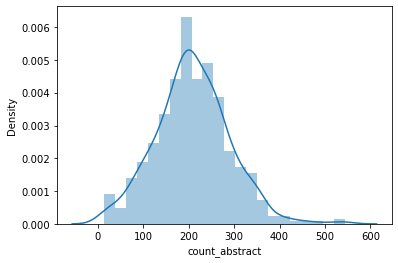

In [65]:
#check abstract word count distribution
sns.distplot(sum_df['count_abstract'])
#Plot word frquency for abstract, text body and unique words

<AxesSubplot:xlabel='count_text', ylabel='Density'>

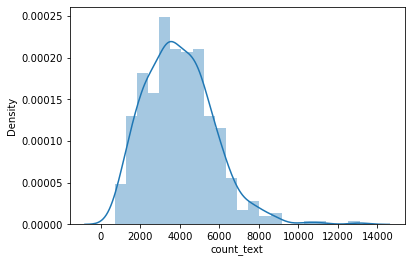

In [66]:
sns.distplot(sum_df['count_text'])

<AxesSubplot:xlabel='count_unique', ylabel='Density'>

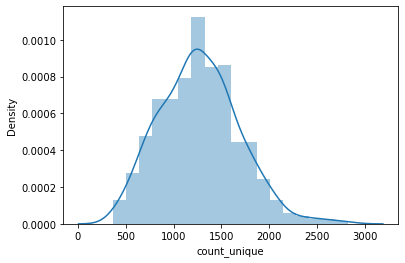

In [67]:
#check abstract word count distribution
sns.distplot(sum_df['count_unique'])

<AxesSubplot:xlabel='article_read_time', ylabel='Density'>

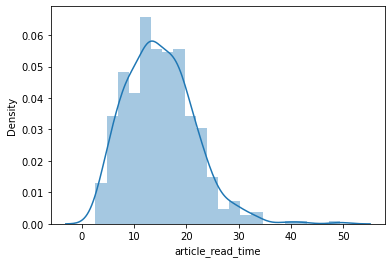

In [68]:
#check abstract word count distribution
sns.distplot(sum_df['article_read_time'])


These three plots give us a good idea of the content we are dealing with. Most papers are between 3000-5000 words in length. The long tails in both plots on the right are caused by outliers. In fact, 98% of the papers are under 10,000 words in length while a select few are over 10,000.
Similarly,98% of the papers have ~2500 unique words, of the total 3,194 unique words.
This gives me an idea of the summarization and the average length of summaries.
Since most of the papers have ~5000 words, a 10% summarization will result in ~500 words.
The default summarization ratio is 20%. However, most people prefer a summary length between 250 to 500 words. 
It takes 15 minutes to read the average article.Reading time goes uo to almost an hour.
This is why I need a summarization tool ASAP.
It usually takes me atleast an hour to understand the article after reading it several times.

- Now that I have gone through the data for the summarization tool,I can use these insights to build the model.
- The capstone_data will be used to model my text summarizer